 # Stochastic Quantum Dynamics with QuTiP
 
 
 We use QuTiP's solvers to study the open dynamics of a quantum system evolving in time. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

### Define the operators and Hamiltonian

In [53]:
# spins
sx_reduced = sigmax()
sy_reduced = sigmay()
sz_reduced = sigmaz()
sp_reduced = sigmap()
sm_reduced = sigmam()

# photons
nph = 4
a_reduced = destroy(nph)

# tensor space
sz = tensor(sz_reduced,qeye(nph))
sx = tensor(sx_reduced,qeye(nph))
sm = tensor(sm_reduced,qeye(nph))
sp = sm.dag()
a = tensor(qeye(2), a_reduced)

# hamiltonians
g = 0.1
Hcav = a.dag()*a
wx = 0.5
Hspin = sz #+ wx*sx
Hint =  g*sx*(a+a.dag())
HintCheck =  g*tensor(sx_reduced,a_reduced+a_reduced.dag())
H = Hcav + Hspin + Hint
np.testing.assert_(Hint == HintCheck)

### Define the initial state

In [54]:
# initial state
psi0_spin = basis(2,0)
psi0_phot = basis(nph,nph-int(nph/2))
psi0 = tensor(psi0_spin,psi0_phot)
rho0 = ket2dm(psi0)

tlist = np.linspace(0,50,2000)

### Photon counting statistics: $\texttt{mcsolve}$

In [64]:
kappa = 0.3
gamma = 0.3
# set dynamics options
my_options = Options(average_states = False, store_states = True)
# solve dynamics
results_mc = mcsolve(H, psi0, tlist, 
                  c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], 
                  options=my_options, progress_bar=True)

# store time evoluted variables
nph_mc_t = results_mc.expect[0]
sz_mc_t = results_mc.expect[1]

10.0%. Run time:   9.33s. Est. time left: 00:00:01:23
20.0%. Run time:  13.67s. Est. time left: 00:00:00:54
30.0%. Run time:  19.32s. Est. time left: 00:00:00:45
40.0%. Run time:  23.39s. Est. time left: 00:00:00:35
50.0%. Run time:  29.08s. Est. time left: 00:00:00:29
60.0%. Run time:  35.08s. Est. time left: 00:00:00:23
70.0%. Run time:  39.37s. Est. time left: 00:00:00:16
80.0%. Run time:  45.12s. Est. time left: 00:00:00:11
90.0%. Run time:  51.61s. Est. time left: 00:00:00:05
100.0%. Run time:  55.82s. Est. time left: 00:00:00:00
Total run time:  56.04s


In [65]:
rho_mc_t = results_mc.states
len(rho_mc_t)
#help(expect)

500

In [66]:
sz_stoch_t = []
nph_stoch_t = []
for i in range(len(rho_mc_t)):
    sz_stoch_t.append(expect(sz,rho_mc_t[i]))
    nph_stoch_t.append(expect(a.dag()*a,rho_mc_t[i]))

### Average master equation: $\texttt{mesolve}$

In [67]:
my_options = Options(average_states = True, store_states = True)
results = mesolve(H, psi0, tlist, 
                  c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], 
                  options=my_options, progress_bar=True)

# store time evoluted variables
nph_t = results.expect[0]
sz_t = results.expect[1]
rho_t = results.states

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.09s. Est. time left: 00:00:00:00
40.0%. Run time:   0.12s. Est. time left: 00:00:00:00
50.0%. Run time:   0.15s. Est. time left: 00:00:00:00
60.0%. Run time:   0.19s. Est. time left: 00:00:00:00
70.0%. Run time:   0.21s. Est. time left: 00:00:00:00
80.0%. Run time:   0.24s. Est. time left: 00:00:00:00
90.0%. Run time:   0.27s. Est. time left: 00:00:00:00
Total run time:   0.30s


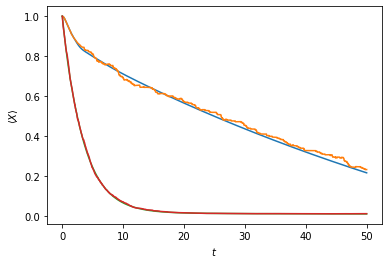

In [68]:
plt.figure()
plt.plot(tlist, sz_t)
plt.plot(tlist, sz_mc_t)
plt.plot(tlist, nph_t/nph/0.5)
plt.plot(tlist, nph_mc_t/nph/0.5)
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle X \rangle$")
plt.show()
plt.close()

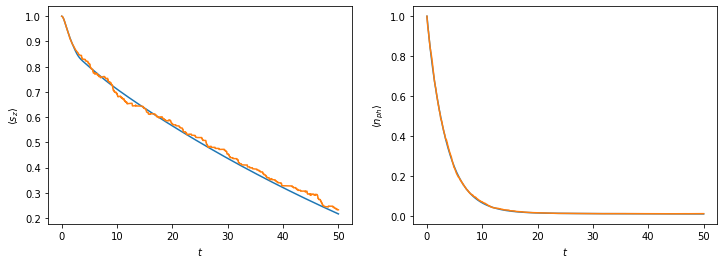

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tlist, sz_t)
plt.plot(tlist, sz_mc_t)
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle s_z \rangle$")
plt.subplot(122)
plt.plot(tlist, nph_t/nph/0.5)
plt.plot(tlist, nph_mc_t/nph/0.5)

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle n_{ph} \rangle$")
plt.show()
plt.close()

### Steady state solver: $\texttt{steadystate}$

In [72]:
rhoss = steadystate(H,[np.sqrt(kappa)*a,np.sqrt(gamma)*sz])
nph_ss= expect(a.dag()*a,rhoss)
sz_ss= expect(sz,rhoss)

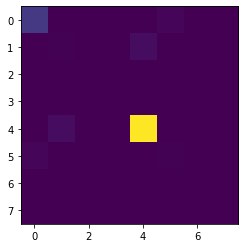

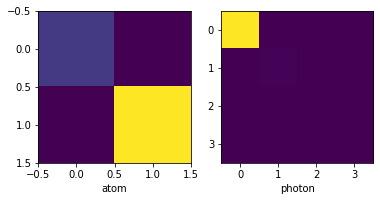

In [76]:
plt.figure()
plt.imshow(abs(rhoss.full()))
plt.show()
plt.close()
plt.figure()
plt.subplot(121)
plt.imshow(abs(ptrace(rhoss,0).full()))
plt.xlabel("atom")
plt.subplot(122)
plt.imshow(abs(ptrace(rhoss,1).full()))
plt.xlabel("photon")
plt.show()
plt.close()

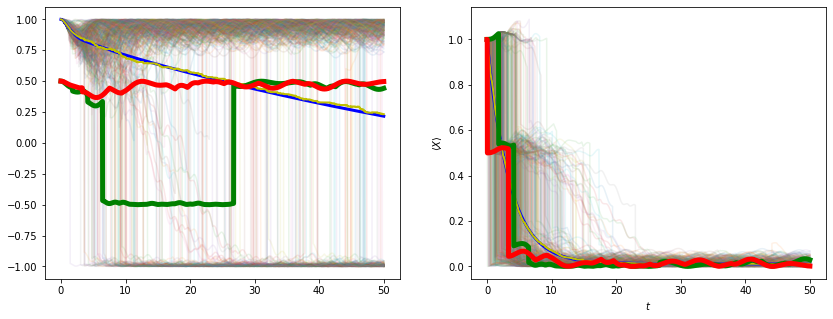

In [71]:
plt.figure(figsize=(14,5))
plt.subplot(121)
for i in range(len(sz_stoch_t)):
    plt.plot(tlist, sz_stoch_t[i],alpha=0.1)

plt.plot(tlist, sz_t,"b",linewidth=3)
plt.plot(tlist, sz_mc_t,"y",linewidth=2)
plt.plot(tlist, sz_stoch_t[4]/nph/0.5,"g",linewidth=5)
plt.plot(tlist, sz_stoch_t[6]/nph/0.5,"r",linewidth=5)
plt.subplot(122)
for i in range(len(sz_stoch_t)):
    plt.plot(tlist, nph_stoch_t[i]/nph/0.5,alpha=0.1)
plt.plot(tlist, nph_t/nph/0.5,"b",linewidth=3)
plt.plot(tlist, nph_mc_t/nph/0.5,"y",linewidth=2)
plt.plot(tlist, nph_stoch_t[4]/nph/0.5,"g",linewidth=5)
plt.plot(tlist, nph_stoch_t[6]/nph/0.5,"r",linewidth=5)
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle X \rangle$")
plt.show()
plt.close()

In [63]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.1
Numpy Version:      1.15.4
Scipy Version:      1.2.1
Cython Version:     0.29.8
Matplotlib Version: 3.1.0
Python Version:     3.7.3
Number of CPUs:     2
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.cite()`
